# Bernstein-Vazirani Algorithm

The Bernstein-Vazirani algorithm is an algorithm that deterministically solves the following problem:

Suppose there is a secret bit string $s = s_{n-1}\cdots s_1 s_0$ and an [oracle](https://dojo.qulacs.org/en/latest/notebooks/8.1_oracle.html) that implements the function

$$
    \begin{equation}
        f(x) = s_0 x_0 \oplus s_1 x_1 \oplus \cdots \oplus s_{n-1} x_{n-1}
    \end{equation}
$$

Find the secret bit string $s$.

We demonstrate how to use QURI Parts to implement the algorithm.

## Building the problem oracle

Now, let's build the quantum circuit that implements the oracle.

In [ ]:
from quri_parts.circuit import QuantumCircuit
from quri_parts.circuit import draw_circuit # >= 0.22.0

def get_bv_oracle(s: int, bit_length: int) -> QuantumCircuit:
    circuit = QuantumCircuit(bit_length + 1)
    for i in range(bit_length):
        this_s = (s >> i) & 1
        if this_s:
            circuit.add_CNOT_gate(i, bit_length)
    return circuit

As an example, let's assume the secret bit string is $1101$ and see what the oracle circuit looks like:

In [ ]:
draw_circuit(get_bv_oracle(0b1101, 4))

                        
                        
----●-------------------
    |                   
    |                   
    |                   
----|-------------------
    |                   
    |                   
    |                   
----|-------●-----------
    |       |           
    |       |           
    |       |           
----|-------|-------●---
    |       |       |   
   _|_     _|_     _|_  
  |CX |   |CX |   |CX | 
--|0  |---|1  |---|2  |-
  |___|   |___|   |___| 


We may confirm that the oracle we implemented is indeed correct. Let's assume that the secret string is $1101$

In [ ]:
import numpy as np
from functools import reduce
import pandas as pd
from quri_parts.core.state import ComputationalBasisState
from quri_parts.qulacs.simulator import evaluate_state_to_vector 

n_bit_length = 4
n_qubits = n_bit_length + 1
s = 0b1101
oracle = get_bv_oracle(s, 4)

recorder = {}
for i in range(2**n_bit_length):
    out_vector = evaluate_state_to_vector(
        ComputationalBasisState(n_qubits, bits=i).with_gates_applied(oracle)
    ).vector

    oracle_evaluted = np.where(out_vector)[0][0] >> n_bit_length
    expected = reduce(lambda x, y: x^y, [((i & s) >> j) & 1 for j in range(n_bit_length)])

    recorder[i] = {"oracle": oracle_evaluted, "expected": expected}

print(pd.DataFrame.from_dict(recorder).to_markdown())

|          |   0 |   1 |   2 |   3 |   4 |   5 |   6 |   7 |   8 |   9 |   10 |   11 |   12 |   13 |   14 |   15 |
|:---------|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|-----:|-----:|-----:|-----:|-----:|-----:|
| oracle   |   0 |   1 |   0 |   1 |   1 |   0 |   1 |   0 |   1 |   0 |    1 |    0 |    0 |    1 |    0 |    1 |
| expected |   0 |   1 |   0 |   1 |   1 |   0 |   1 |   0 |   1 |   0 |    1 |    0 |    0 |    1 |    0 |    1 |


Given the table above, we have confirmed that the oracle implemention is indeed correct.

## Building the Bernstein-Vazirani algorithm circuit

Now, let's build the circuit that implements the Bernstein-Vazirani algorithm. The circuit looks like:

![png](bv_algo_circuit.png)

In [ ]:
def get_bv_algorithm_circuit(oracle: QuantumCircuit) -> QuantumCircuit:

    bit_length = oracle.qubit_count - 1
    circuit = QuantumCircuit(oracle.qubit_count)
    
    circuit.add_X_gate(bit_length)

    for i in range(bit_length + 1):
        circuit.add_H_gate(i)

    circuit.extend(oracle)
    
    for i in range(bit_length + 1):
        circuit.add_H_gate(i)

    return circuit

Now, let's look at the what the circuit implementing the algorithm looks like.

In [ ]:
oracle = get_bv_oracle(0b110101, 6)
draw_circuit(get_bv_algorithm_circuit(oracle))

   ___                     ___                          
  | H |                   | H |                         
--|1  |-------------●-----|12 |-------------------------
  |___|             |     |___|                         
   ___     ___      |                                   
  | H |   | H |     |                                   
--|2  |---|13 |-----|-----------------------------------
  |___|   |___|     |                                   
   ___              |              ___                  
  | H |             |             | H |                 
--|3  |-------------|-------●-----|14 |-----------------
  |___|             |       |     |___|                 
   ___     ___      |       |                           
  | H |   | H |     |       |                           
--|4  |---|15 |-----|-------|---------------------------
  |___|   |___|     |       |                           
   ___              |       |              ___          
  | H |             |       |  

Finally, let's construct a function that executes the algorithm. As the algorithm is deterministic, it can be executed using a sampler with only 1 shot.

In [ ]:
from quri_parts.qulacs.sampler import create_qulacs_vector_sampler

def get_secret_string(oracle: QuantumCircuit, n_shot: int = 1) -> dict[str, int]:
    algorithm = get_bv_algorithm_circuit(oracle)
    n_qubits = algorithm.qubit_count
    
    sampler = create_qulacs_vector_sampler()
    sampling_cnt = sampler(algorithm, n_shot)

    get_secret_string_from_int = lambda s: bin(s)[2:].zfill(n_qubits)[1:]

    return {get_secret_string_from_int(s): v for s, v in sampling_cnt.items()}

Now, let's execute the algorithm with the secret string fed to the oracle being $s = 011101$.

In [ ]:
bit_length = 6
s = 0b011101
oracle = get_bv_oracle(s, bit_length)
next(iter(get_secret_string(oracle)))

'011101'

The algorithm indeed gives us the desiresd result as expected.

### Showing that the algorithm is deterministic

To ensure the algorithm is indeed deterministic, let's run the circuit 1000 times and see if it gives the exact same result every time.

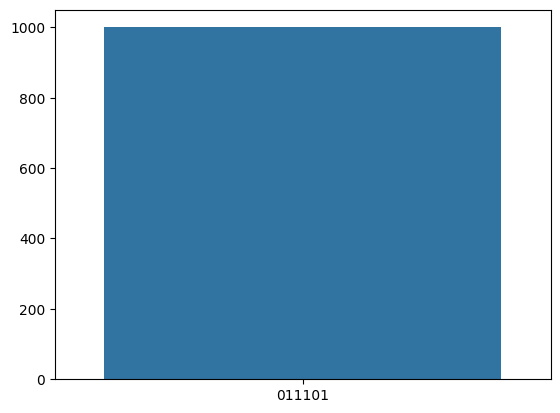

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

counts = get_secret_string(oracle, n_shot=1000)
sns.barplot(counts, x=counts.keys(), y=counts.values())
plt.show()

Given that every execution gives the exact same result, we have confirmed that the algorithm is deterministic